In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [2]:
df = pd.read_csv('../data/processed/vehicle_maintenance_features.csv')

In [3]:
X = df.drop(columns=['failure_risk', 'unit_number'])
y = df['failure_risk']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [4]:
# Train Baseline Model
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

print("Logistic Regression ROC-AUC:", roc_auc_score(y_test, y_prob_lr))

Logistic Regression ROC-AUC: 0.9904191616766467


c:\Python 3.9.5\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

lr_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=3000))
])

lr_pipeline.fit(X_train, y_train)

y_prob_lr = lr_pipeline.predict_proba(X_test)[:, 1]

print("Logistic Regression ROC-AUC:", roc_auc_score(y_test, y_prob_lr))


Logistic Regression ROC-AUC: 0.9922565008232384


In [7]:
# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)

y_prob_rf = rf.predict_proba(X_test)[:, 1]
print("Random Forest ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


Random Forest ROC-AUC: 0.992858522586164


In [8]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train, y_train)

y_prob_xgb = xgb.predict_proba(X_test)[:, 1]
print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))


XGBoost ROC-AUC: 0.9964246621963446


In [9]:
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]


In [10]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Accuracy: 0.9757693239641386
Precision: 0.9347826086956522
Recall: 0.9016129032258065
ROC-AUC: 0.9964246621963446


In [11]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3507
           1       0.93      0.90      0.92       620

    accuracy                           0.98      4127
   macro avg       0.96      0.95      0.95      4127
weighted avg       0.98      0.98      0.98      4127



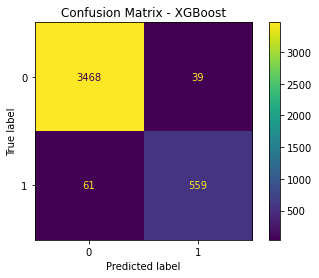

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix - XGBoost")
plt.show()


In [14]:
import matplotlib.pyplot as plt

importance = xgb.feature_importances_
features = X.columns

feat_imp = pd.Series(importance, index=features).sort_values(ascending=False)

feat_imp.head(10)


sensor_4_roll_mean     0.274680
sensor_11_roll_mean    0.212880
sensor_17_roll_mean    0.052260
sensor_15_roll_mean    0.035069
sensor_20_roll_mean    0.029081
sensor_3_roll_mean     0.023579
sensor_9               0.022327
sensor_9_lag1          0.021963
sensor_2_roll_mean     0.020014
sensor_9_roll_mean     0.018473
dtype: float32

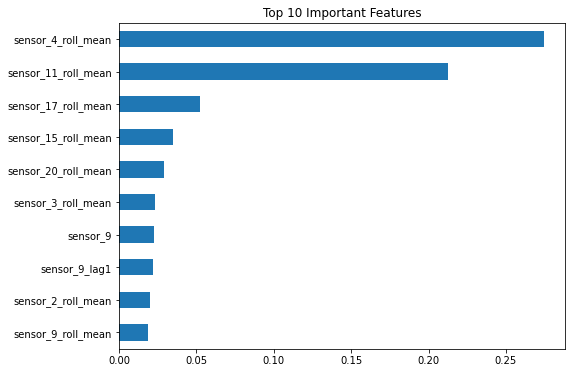

In [ ]:
# Visualize Top Features
# Rolling mean and rate-of-change features dominate, validating degradation-based feature engineering
plt.figure(figsize=(8, 6))
feat_imp.head(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.gca().invert_yaxis()
plt.show()


In [16]:
import joblib
import os

os.makedirs('../deployment', exist_ok=True)

# Save trained XGBoost model
joblib.dump(xgb, '../deployment/xgb_model.pkl')

# Save feature column order
joblib.dump(X.columns.tolist(), '../deployment/feature_columns.pkl')

print("Model and feature columns saved successfully")


Model and feature columns saved successfully


In [17]:
sample_input = X.iloc[0].to_dict()
sample_input


{'time_cycles': 1.0,
 'op_setting_1': -0.0007,
 'op_setting_2': -0.0004,
 'op_setting_3': 100.0,
 'sensor_1': 518.67,
 'sensor_2': 641.82,
 'sensor_3': 1589.7,
 'sensor_4': 1400.6,
 'sensor_5': 14.62,
 'sensor_6': 21.61,
 'sensor_7': 554.36,
 'sensor_8': 2388.06,
 'sensor_9': 9046.19,
 'sensor_10': 1.3,
 'sensor_11': 47.47,
 'sensor_12': 521.66,
 'sensor_13': 2388.02,
 'sensor_14': 8138.62,
 'sensor_15': 8.4195,
 'sensor_16': 0.03,
 'sensor_17': 392.0,
 'sensor_18': 2388.0,
 'sensor_19': 100.0,
 'sensor_20': 39.06,
 'sensor_21': 23.419,
 'sensor_1_roll_mean': 518.67,
 'sensor_1_roll_std': 0.0,
 'sensor_2_roll_mean': 642.208,
 'sensor_2_roll_std': 0.2347764894532603,
 'sensor_3_roll_mean': 1587.03,
 'sensor_3_roll_std': 4.075677857731061,
 'sensor_4_roll_mean': 1403.206,
 'sensor_4_roll_std': 2.1594397421554934,
 'sensor_5_roll_mean': 14.62,
 'sensor_5_roll_std': 0.0,
 'sensor_6_roll_mean': 21.61,
 'sensor_6_roll_std': 0.0,
 'sensor_7_roll_mean': 554.164,
 'sensor_7_roll_std': 0.2862341

In [ ]:
import json
#  to convert to JSON format
json.dumps(sample_input)


'{"time_cycles": 1.0, "op_setting_1": -0.0007, "op_setting_2": -0.0004, "op_setting_3": 100.0, "sensor_1": 518.67, "sensor_2": 641.82, "sensor_3": 1589.7, "sensor_4": 1400.6, "sensor_5": 14.62, "sensor_6": 21.61, "sensor_7": 554.36, "sensor_8": 2388.06, "sensor_9": 9046.19, "sensor_10": 1.3, "sensor_11": 47.47, "sensor_12": 521.66, "sensor_13": 2388.02, "sensor_14": 8138.62, "sensor_15": 8.4195, "sensor_16": 0.03, "sensor_17": 392.0, "sensor_18": 2388.0, "sensor_19": 100.0, "sensor_20": 39.06, "sensor_21": 23.419, "sensor_1_roll_mean": 518.67, "sensor_1_roll_std": 0.0, "sensor_2_roll_mean": 642.208, "sensor_2_roll_std": 0.2347764894532603, "sensor_3_roll_mean": 1587.03, "sensor_3_roll_std": 4.075677857731061, "sensor_4_roll_mean": 1403.206, "sensor_4_roll_std": 2.1594397421554934, "sensor_5_roll_mean": 14.62, "sensor_5_roll_std": 0.0, "sensor_6_roll_mean": 21.61, "sensor_6_roll_std": 0.0, "sensor_7_roll_mean": 554.164, "sensor_7_roll_std": 0.2862341698679803, "sensor_8_roll_mean": 2388